In [1]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [2]:
hex_scheduled = _hex_json.loads("false")

In [3]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [4]:
hex_user_attributes = _hex_json.loads("{}")

In [5]:
hex_run_context = _hex_json.loads("\"logic\"")

In [6]:
hex_timezone = _hex_json.loads("\"Asia/Dubai\"")

In [7]:
hex_project_id = _hex_json.loads("\"71f2594d-0153-4edf-bddb-0244d149f1f8\"")

In [8]:
hex_project_name = _hex_json.loads("\"COURSERA GP: Snowflake for Data Science: Intro to Snowpark ML for Python_learner Guide_Final\"")

In [9]:
hex_status = _hex_json.loads("\"\"")

In [10]:
hex_categories = _hex_json.loads("[]")

In [11]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

# TASK 2 : Set-up your Snowpark for Python workspace
- In this Task, we will walk through a how to connect HEX notebook to your Snowflake Trial Account.

#### _**a-Import Libraries**_



In [12]:
# Snowpark for Python
from snowflake.snowpark.version import VERSION
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline

# Data Science Libs
import numpy as np
import pandas as pd

# Misc
import joblib

# warning suppresion
import warnings; warnings.simplefilter('ignore')

#### _**b- Establish Secure Connection to Snowflake**_



In [13]:
from snowflake.snowpark import Session
session = Session.builder.config("connection_name", 'DIAMONDS_CONNECTION',).create()

In [14]:
# Verify connectivity to Snowflake
snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

User                        : JAMESMCINTYRE
Role                        : "ACCOUNTADMIN"
Database                    : "DIAMONDS"
Schema                      : "PUBLIC"
Warehouse                   : "PC_HEX_WH"
Snowflake version           : 9.5.2
Snowpark for Python version : 1.28.0


# TASK 3 : Data Preprocessing: Transform categorical variables
- In this Task, we will walk through data transformations that are included in the Snowpark ML Preprocessing API.

*We will illustrate a few transformation functions availabe in Snowpark ML, the rest can be found in the [documentation](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-preprocessing).*

#### _a- Data Loading_



In [15]:
# Specify the table name where we stored the diamonds dataset
# ** ONLY Change this only if you named your table something else in the data ingest notebook **
DIAMONDS_TABLE = 'diamonds'
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{DIAMONDS_TABLE}"
input_tbl

'"DIAMONDS"."PUBLIC".diamonds'

In [16]:
# First, we read-in the data from a Snowflake table into a Snowpark DataFrame
diamonds_df = session.table(input_tbl)

# Let's visualise the Data
diamonds_df.show()

# Describe Snowpark Datafarame
diamonds_df.describe().show()


----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |"DEPTH"  |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |61.5     |
|0.21     |E        |SI1        |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |59.8     |
|0.23     |E        |VS1        |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |56.9     |
|0.29     |I        |VS2        |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |62.4     |
|0.31     |J        |SI2        |58.0         |335      |4.34  |4.35  |2.75  |GOOD       |63.3     |
|0.24     |J        |VVS2       |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |62.8     |
|0.24     |I        |VVS1       |57.0         |336      |3.95  |3.98  |2.47  |VERY_GOOD  |6

In [17]:
# Convert Snowpark DF API into Pandas DF, then check for missing values and categorical variables in the dataset
diamonds_df.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53920 entries, 0 to 53919
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CARAT      53920 non-null  float64
 1   COLOR      53920 non-null  object 
 2   CLARITY    53920 non-null  object 
 3   TABLE_PCT  53920 non-null  float64
 4   PRICE      53920 non-null  int16  
 5   X          53920 non-null  float64
 6   Y          53920 non-null  float64
 7   Z          53920 non-null  float64
 8   CUT        53920 non-null  object 
 9   DEPTH      53920 non-null  float64
dtypes: float64(6), int16(1), object(3)
memory usage: 3.8+ MB


<img src="https://4cs.gia.edu/wp-content/uploads/2012/05/Cut-Anatomy-of-Diamond.png" style="height:200px" />

_**Features**_

- **Price :**, in US dollars ($326--$18,823)This is the target column containing tags for the features. 

The 4 Cs of Diamonds:

- **Carat**, ,**(0.2--5.01)**, The carat is the diamond’s physical weight measured in metric carats.  One carat equals 1/5 gram and is subdivided into 100 points. Carat weight is the most objective grade of the 4Cs. 
- _**Cut (Fair, Good, Very Good, Premium, Ideal):**_, The quality of the cut. The more precise the diamond is cut, the more captivating the diamond is to the eye thus of high grade.
- _**Clarity (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)):**_, Diamonds can have internal characteristics known as inclusions or external characteristics known as blemishes. Diamonds without inclusions or blemishes are rare; however, most characteristics can only be seen with magnification.
- _**Color (from J (worst) to D (best)): **_,The color of gem-quality diamonds occurs in many hues. In the range from colorless to light yellow or light brown. Colorless diamonds are the rarest. Other natural colors (blue, red, pink for example) are known as "fancy,” and their color grading is different from white colorless diamonds.
- Dimensions: 
  - **X: **,length in mm (0--10.74)
  - **Y: **,width in mm (0--58.9)
  - **Z: **,depth in mm (0--31.8)



#### b-Transform `COLOR`, `CLARITY` and `CUT` from categorical to numerical values using `OrdinalEncoder`



In [18]:
import snowflake.ml.modeling.preprocessing as snowml

# Encode CUT, CLARITY, and COLOR to preserve ordinal importance
categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=["CUT", "CLARITY", "COLOR"], 
                                    output_cols=["CUT_OE", "CLARITY_OE","COLOR_OE"], 
                                    categories=categories
                                )

ord_encoded_diamonds_df = snowml_oe.fit(diamonds_df).transform(diamonds_df)

# Show the encoding
print(snowml_oe._state_pandas)

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9
15        COLOR          D       0
16        COLOR          E       1
17        COLOR          F       2
18        COLOR          G       3
19        COLOR          H       4
20        COLOR          I       5
21        COLOR          J       6


In [19]:
#show the results of the OrdinalEncoder transformer
ord_encoded_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OE"  |"CLARITY_OE"  |"COLOR_OE"  |"CARAT"  |"COLOR"  |"CLARITY"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |"DEPTH"  |
-------------------------------------------------------------------------------------------------------------------------------------------
|0.0       |6.0           |1.0         |0.23     |E        |SI2        |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |61.5     |
|1.0       |5.0           |1.0         |0.21     |E        |SI1        |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |59.8     |
|3.0       |3.0           |1.0         |0.23     |E        |VS1        |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |56.9     |
|1.0       |4.0           |5.0         |0.29     |I        |VS2        |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |62.4     |
|3.0       |6.0     

# PRACTICE TASK : Normalise Numerical Column `CARAT` using `MinMaxScaler`

SNOWPARK ML Modeling preprocessing [Documentation](https://docs.snowflake.com/developer-guide/snowpark-ml/snowpark-ml-modeling)



In [20]:
from snowflake.ml.modeling.preprocessing import MinMaxScaler
# hint : to get help run: 
# help(MinMaxScaler)

In [21]:
#MinMaxScaler scales the data to a fixed range, typically between 0 and 1

# Normalize the CARAT column
snowml_mms = MinMaxScaler(input_cols='CARAT', output_cols='CARAT_NORM')

# Call : 
# a-fit(X[, y]) Compute the minimum and maximum to be used for later scaling.
# b-transform(X) Scale features of X according to feature_range.

normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Check Results : Call .Describe() then .Show() Results
normalized_diamonds_df.describe().show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"CARAT_NORM"         |"CARAT"             |"COLOR"  |"CLARITY"  |"TABLE_PCT"         |"PRICE"             |"X"                |"Y"                |"Z"                 |"CUT"      |"DEPTH"             |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |53920.0              |53920.0             |53920    |53920      |53920.0             |53920.0             |53920.0            |53920.0            |53920.0             |53920      |53920.0             |
|mean       |0.1242615918246482   |0.79769826          |NULL     |NULL       |57.4568342          |3930.993231         |5.73162685         |

# TASK 4 : Build Preprocessing Pipeline
- In this Task, we will build a preprocessing pipeline to be used for both the ML training & inference steps to have standarized feature transformations.

#### _a- Categorise all the features for processing_



In [22]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

#### _b- Build the pipeline_



In [23]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(
                    input_cols=CATEGORICAL_COLUMNS,
                    output_cols=CATEGORICAL_COLUMNS_OE,
                    categories=categories,
                )
            )
    ]
)

PIPELINE_FILE = r'C:\Users\James\GitRepos\SnowflakePractice_Diamonds\preprocessing_pipeline.joblib'

# Lets create joblib file of the pipeline and save it locally
joblib.dump(preprocessing_pipeline, PIPELINE_FILE)

['C:\\Users\\James\\GitRepos\\SnowflakePractice_Diamonds\\preprocessing_pipeline.joblib']

#### _c- Save the pipleine into Snowflake stage as a joblib file_



In [24]:
# You can also save the pipeline joblibfile file into a Snowflake Internal Stage


session.file.put(PIPELINE_FILE, "ML_FILES", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=1732, target_size=976, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

# TASK 5 : Build an `XGBoost` Regression Model
- In this Task, we will illustrate how to train an XGBoost model with the diamonds dataset using the Snowpark ML Model API. 

The Snowpark ML Model API currently supports sklearn, xgboost, and lightgbm models, for more details check out Snowflake Documentation : https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling 

#### _a- Import Libraries_



In [25]:
# Snowpark ML
from snowflake.ml.modeling.xgboost import XGBRegressor
# For All Snowpark ML Modeling Classes visit https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling

# joblib
import joblib

#### _b- Load the data & preprocessing pipeline_



In [26]:
# Load Diamonds Table from Snowflake
#diamonds_df = session.table(input_tbl)
diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"TABLE_PCT"  |"PRICE"  |"X"   |"Y"   |"Z"   |"CUT"      |"DEPTH"  |
----------------------------------------------------------------------------------------------------
|0.23     |E        |SI2        |55.0         |326      |3.95  |3.98  |2.43  |IDEAL      |61.5     |
|0.21     |E        |SI1        |61.0         |326      |3.89  |3.84  |2.31  |PREMIUM    |59.8     |
|0.23     |E        |VS1        |65.0         |327      |4.05  |4.07  |2.31  |GOOD       |56.9     |
|0.29     |I        |VS2        |58.0         |334      |4.20  |4.23  |2.63  |PREMIUM    |62.4     |
|0.31     |J        |SI2        |58.0         |335      |4.34  |4.35  |2.75  |GOOD       |63.3     |
|0.24     |J        |VVS2       |57.0         |336      |3.94  |3.96  |2.48  |VERY_GOOD  |62.8     |
|0.24     |I        |VVS1       |57.0         |336      |3.95  |3.98  |2.47  |VERY_GOOD  |6

In [27]:
# Load the preprocessing pipeline object
#preprocessing_pipeline = joblib.load('preprocessing_pipeline.joblib')

# Visualise the Pipeline 
preprocessing_pipeline.to_sklearn()

Pipeline(steps=[('OE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OE',
                                                  OrdinalEncoder(categories=[array(['IDEAL', 'PREMIUM', 'VERY_GOOD', 'GOOD', 'FAIR'], dtype='<U9'),
                                                                             array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='<U1'),
                                                                             array(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3'],
      dtype='<U4')]),
                                                  ['CUT', 'COLOR',
                                                   'CLARITY'])]))])

In [28]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] 
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']

#### _c- Build XGBoost Regression Model_



In [29]:
# Split the data into train and test sets
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(weights=[0.9,0.1], seed=0)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(diamonds_train_df).transform(diamonds_train_df)
test_df = preprocessing_pipeline.fit(diamonds_test_df).transform(diamonds_test_df)

In [30]:
# Define the XGBRegressor
regressor = XGBRegressor(
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result= regressor.predict(test_df)

Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


#### _d- Analyse Model Accuracy using Snowpark ML's R-2 Score._



In [31]:
from snowflake.ml.modeling.metrics import r2_score

# Show Result
result.select("PRICE", "PREDICTED_PRICE").show()

# Model Accuracy using R-2 Score
print('Acccuracy:', r2_score(df=result,y_true_col_name="PRICE",y_pred_col_name="PREDICTED_PRICE"))

--------------------------------
|"PRICE"  |"PREDICTED_PRICE"   |
--------------------------------
|351      |357.13226318359375  |
|353      |329.08197021484375  |
|355      |356.8968505859375   |
|357      |420.1815185546875   |
|554      |558.5751342773438   |
|554      |494.9957580566406   |
|2757     |2707.064697265625   |
|2759     |2961.092529296875   |
|2759     |2779.14501953125    |
|2762     |2860.9501953125     |
--------------------------------

Acccuracy: 0.9818281123315649


#### _e- Plot Actual Vs Predicted _



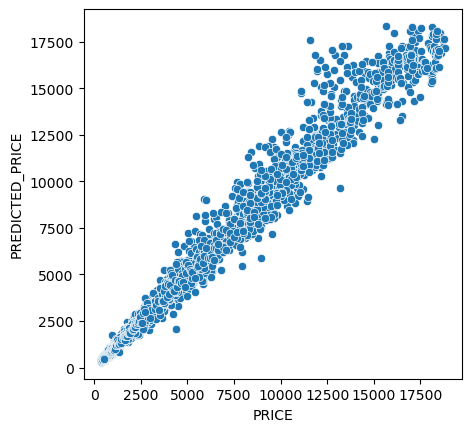

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = result.to_pandas(), x="PRICE", y = "PREDICTED_PRICE")
plt.gca().set_aspect(1)


# PRACTICE TASK : Try different Regression Model `LinearRegression`  

In [33]:
# Import LinearRegression 
from snowflake.ml.modeling.linear_model import LinearRegression

In [34]:
# Define the LinearRegression
lr = LinearRegression(
    input_cols = CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols = LABEL_COLUMNS,
    output_cols = OUTPUT_COLUMNS
)


# Train
lr.fit(train_df)

# Predict
lr_result = lr.predict(test_df)

Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


**-->** Navigate to Snowflake Query History to check how Snowflake translates and executes your Python queries 



In [35]:
# Show Result   
lr_result.select("PRICE", "PREDICTED_PRICE").show()


# Model Accuracy using R-2 Score
r2_score(df=lr_result, y_true_col_name="PRICE", y_pred_col_name='PREDICTED_PRICE')


---------------------------------
|"PRICE"  |"PREDICTED_PRICE"    |
---------------------------------
|351      |-1962.4246206274202  |
|353      |-1828.7377348260125  |
|355      |-873.8059706831318   |
|357      |86.84978741104715    |
|554      |-1274.9767080486235  |
|554      |-17.238202340062344  |
|2757     |2919.2756342829625   |
|2759     |3363.2589332800444   |
|2759     |3494.63798281837     |
|2762     |3410.660540832665    |
---------------------------------



0.9110521068493247

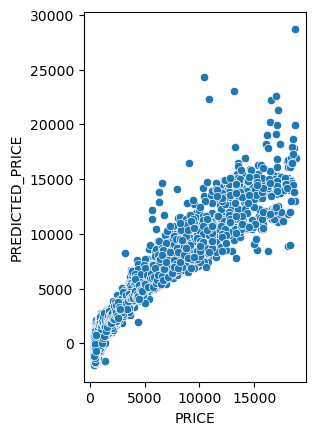

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = lr_result.to_pandas(), x="PRICE", y = "PREDICTED_PRICE")
plt.gca().set_aspect(1)

# TASK 6: Fine Tune Model's Hyperparameters using `GridSearchCV()`

In [37]:
#Import Libraries
from snowflake.ml.modeling.model_selection import GridSearchCV
#help(GridSearchCV)

#### _a- Use GridSearchCV to find the best fitting model_



In [38]:
# from sklearn.metrics import get_scorer_names
# get_scorer_names()

In [39]:
# Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

grid_search = GridSearchCV(
    estimator=regressor, # same XGBOOST model which we trained earlier
    param_grid={
        "n_estimators":[100,200,300, 400, 500], # Number of boosting rounds
        "learning_rate":[0.1,0.2,0.3, 0.4, 0.5], # Step size shrinkage to prevent overfitting
    },
    n_jobs = -1, #Number of jobs to run in parallel. -1 means using all processors.
    scoring="r2",
    cv=5, # 5-fold cross-validation
    input_cols=CATEGORICAL_COLUMNS_OE+NUMERICAL_COLUMNS,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

# Train hypertuned model 
grid_search.fit(train_df)

Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


> **NOTE**>  : Process will take ~2.5min to run, in order to accelerate it, increase the size of your Snowflake virtual Warehouse.



In [40]:
# Best Estimator (model) Hyperparameters
grid_search.to_sklearn().best_params_

{'learning_rate': 0.2, 'n_estimators': 500}

> **NOTE**>  : Based on our Grid search results above the best estimator with the lowest R-2 Score hyper-parameters are learning_rate=0.1 and n_estimator=200.



#### b- Calculate R-2 Score based on best estimator 



In [41]:
# Predict Price using Test set using best estimator (model)
result_optimal_model = grid_search.predict(test_df)

# Analyze results using R-2 Score 
print('Acccuracy of Hypertuned XGBOOST Model:', r2_score(df=result_optimal_model,y_true_col_name="PRICE",y_pred_col_name="PREDICTED_PRICE"))
print('Acccuracy of Initial XGBOOST Model:', r2_score(df=result,y_true_col_name="PRICE",y_pred_col_name="PREDICTED_PRICE"))

Acccuracy of Hypertuned XGBOOST Model: 0.981543931521815
Acccuracy of Initial XGBOOST Model: 0.9818281123315649


# TASK 7: Deploy the model as a Vectorized User-Defined Function (UDF)

> ___**Note:**___> _ When you call `model.predict()` function Snowpark ML creates a temporary UDF, so in order to persist as a permanent UDF, we'll need to define our own UDF.  -- Navigate to Snowflake Query History to see executed queries -- _



In [42]:
#import libraries 
import joblib
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.preprocessing import OrdinalEncoder
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.snowpark import types as T
import snowflake.snowpark.functions as F
import cachetools
import pandas as pd

#### _a- Create the end to end pipeline_



In [43]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"]
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

# Define the end to end pipeline that contains Transforms (preprocessing) and Estimator (optimal XGBRegressor model)
pipe = Pipeline(
    steps=[
        ("OE", OrdinalEncoder(
            input_cols= CATEGORICAL_COLUMNS,  
            output_cols= CATEGORICAL_COLUMNS_OE, 
            categories = categories,  
            drop_input_cols=True)
            ),
        ("regressor", XGBRegressor(
            learning_rate = 0.1, # Add Best best_params_ Results here 
            n_estimators = 200,  # Add Best best_params_ Results here 
            input_cols=CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS, 
            label_cols=["PRICE"], 
            output_cols=['PREDICTED_PRICE'], 
            n_jobs=-1)
            )
    ]
)

# Random split
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(weights=[0.9,0.1], seed =0)

# Train the model and convert it to sklearn pipeline
xgb_optimal_model = pipe.fit(diamonds_train_df).to_sklearn()

Package 'snowflake-telemetry-python' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


#### b- Save the optimal pipeline within a Snowflake Internal Stage



In [44]:
from sklearn import set_config
set_config(display="diagram")
xgb_optimal_model

Pipeline(steps=[('OE',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OE',
                                                  OrdinalEncoder(categories=[array(['IDEAL', 'PREMIUM', 'VERY_GOOD', 'GOOD', 'FAIR'], dtype='<U9'),
                                                                             array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='<U1'),
                                                                             array(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3'],
      dtype='<U4')]),
                                                  [7, 1, 2])])),
                ('filter_input_cols_for_estimato...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=-1,
                              num_parallel_tree=None, random_state=None, ...))])

In [45]:
# Define a file name for the model
MODEL_FILE = 'xgb_optimal_pipe.joblib'

# Serialize and save the model to a file
joblib.dump(xgb_optimal_model, MODEL_FILE)

# Upload the model file to the specified stage
session.file.put(MODEL_FILE, "@ML_FILES", overwrite=True, auto_compress=False)

[PutResult(source='xgb_optimal_pipe.joblib', target='xgb_optimal_pipe.joblib', source_size=839432, target_size=839440, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

#### c- Register the model as a Vectorized UDF



_Vectorized Python UDFs let you define Python functions that receive batches of input rows as Pandas DataFrames and return batches of results as Pandas arrays or Series. You call vectorized Python UDFs the same way you call other Python UDFs.

Advantages of using vectorized Python UDFs compared to the default row-by-row processing pattern include:

_

- _The potential for better performance if your Python code operates efficiently on batches of rows.
_
- _Less transformation logic is required if you are calling into libraries that operate on Pandas DataFrames or Pandas arrays._

_For more details please visit _[Snowflake Documentation](https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-batch)_._



In [48]:
import sklearn 
sklearn.__version__

'1.5.2'

In [49]:
# Define a function to read the model from a file
@cachetools.cached(cache={})
def read_file(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m


# Create a vectorized UDF for batch inference
@F.udf(name="predict_diamond_price",
        is_permanent=True,
        stage_location = '@ML_FILES',
        imports=['@ML_FILES/xgb_optimal_pipe.joblib'],
        packages=['snowflake-ml-python', 'joblib', 'scikit-learn==1.5.2', 'xgboost==2.1.1', 'cachetools'],
        replace=True,
        session=session)
def predict_diamond_price(pd_input: T.PandasDataFrame[str, str, str, float, float, float, float, float, float]) -> T.PandasSeries[float]:
        # Make sure you have the columns in the expected order in the Pandas DataFrame
    features = ["CUT", "COLOR", "CLARITY", "CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]
    pd_input.columns =  features
    model = read_file('xgb_optimal_pipe.joblib')             
    prediction = model.predict(pd_input)       
    return prediction              

#### d-Call the UDF and Predict Price for New Diamonds Table



In [50]:
# Create a Snowpark DF containing Diamonds_NEW Table
new_diamonds = session.table('DIAMONDS_NEW') 

# Apply the UDF to your DataFrame
new_diamonds_w_prediction = new_diamonds.with_column("PREDICTED_PRICE", F.call_function("predict_diamond_price", 
                                    F.col("CUT"), F.col("COLOR"), F.col("CLARITY"), 
                                    F.col("CARAT"), F.col("DEPTH"), F.col("TABLE_PCT"), 
                                    F.col("X"), F.col("Y"), F.col("Z"))
                                    )

# # Show the result
# new_diamonds_w_prediction.show()

In [51]:
# Show the result

new_diamonds_w_prediction.show()

---------------------------------------------------------------------------------------------------------------
|"CARAT"  |"COLOR"  |"CLARITY"  |"TABLE_PCT"  |"X"   |"Y"   |"Z"   |"CUT"      |"DEPTH"  |"PREDICTED_PRICE"   |
---------------------------------------------------------------------------------------------------------------
|1.23     |H        |SI2        |57           |6.98  |6.94  |4.22  |IDEAL      |60.6     |5562.8505859375     |
|1.22     |E        |VVS1       |60           |6.87  |6.85  |4.19  |PREMIUM    |61.1     |13805.7587890625    |
|1.28     |J        |SI1        |56           |7.13  |7.00  |4.37  |PREMIUM    |61.9     |5343.83984375       |
|0.24     |E        |VVS1       |58           |4.03  |4.01  |2.44  |PREMIUM    |60.7     |670.1036987304688   |
|1.01     |H        |VS1        |57           |6.47  |6.38  |3.96  |PREMIUM    |61.6     |5321.9072265625     |
|0.33     |I        |SI1        |59           |4.50  |4.54  |2.73  |PREMIUM    |60.4     |471.6105346679

#### e-Save Predictions in a  new Snowflake Table 



In [52]:
# Write predictions to a Snowflake table
new_diamonds_w_prediction.write.mode('overwrite').save_as_table('diamonds_new_w_predictions')

In [53]:
session.close()

# ------- END OF THE GUIDED PROJECT.... CONGRATULATIONS !! -------

